### Import the required libraries

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import random
import torch, torchtext
from torchtext import data
import torch.optim as optim

import os, pickle

import torch.nn as nn
import torch.nn.functional as F
import json

### Upload the tweet csv file

In [2]:


df = pd.read_csv( "/content/tweets.csv")  #"/content/orig_swap_del_tlt_insDF.csv") #   "/content/tweets.csv")
df.tail()

,tweets,labels
1359,@liberalminds Its trending idiot.. Did you loo...,0
1360,RT @AstoldByBass: #KimKardashiansNextBoyfriend...,0
1361,RT @GatorNation41: gas was $1.92 when Obama to...,1
1362,"@xShwag haha i know im just so smart, i mean y...",1
1363,#OBAMA: DICTATOR IN TRAINING. If he passes t...,0


In [3]:
df.shape

(1364, 2)

In [4]:
df.labels.value_counts()

0    931
1    352
2     81
Name: labels, dtype: int64

### Set a seed value to enable repeatibility of model performance

In [5]:
# Manual Seed
SEED = 43
torch.manual_seed(SEED)

### Create Field and LabelField variables to hold the comment and label information

**Field** - Defines a datatype together with instructions for converting to Tensor.

Field class models common text processing datatypes that can be represented by tensors. It holds a Vocab object that defines the set of possible values for elements of the field and their corresponding numerical representations. The Field object also holds other parameters relating to how a datatype should be numericalized, such as a tokenization method and the kind of Tensor that should be produced.

1.   The tweet will be stored in **Tweet** Field object
2.   The label will be stored in **Label** LabelField object


In [6]:
Tweet = torchtext.legacy.data.Field(sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True)
Label = torchtext.legacy.data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)

#### Map the 2 variables to column header 

| Column header | Variable name |
| --- | --- |
| **tweet** | Tweet |
| **label** | Label |

In [7]:
fields = [('tweet', Tweet), ('label', Label)]

### Create a list of example

by doing list comprehension of the tweet and label dataframe generated from the csv file

In [8]:
example = [torchtext.legacy.data.Example.fromlist([df.tweets[i],df.labels[i]], fields) for i in range(df.shape[0])] 

### Create the Dataset 

by providing the above list of examples and the field mapping

In [9]:
twitterDataset = torchtext.legacy.data.Dataset(example, fields)

In [10]:
twitterDataset

### Split the dataset into

train and validation in the ratio of **85:15**

In [11]:
(train, valid) = twitterDataset.split(split_ratio=[85, 15], random_state = random.seed(SEED))

In [12]:
len(train), len(valid)

(1159, 205)

In [13]:
train.fields

{'label': <torchtext.legacy.data.field.LabelField at 0x7fb86fe4d550>,
 'tweet': <torchtext.legacy.data.field.Field at 0x7fb8c5761a10>}

### a training example

In [14]:
vars(train.examples[15])

{'label': 0,
 'tweet': ['In',
  'his',
  'teen',
  'years',
  ',',
  'Obama',
  'has',
  'been',
  'known',
  'to',
  'use',
  'marijuana',
  'and',
  'cocaine',
  '.']}

A Vocab object defines the set of possible values for elements of the field and their corresponding numerical representations.

Create Vocab object of the tweets and labels

In [15]:
Tweet.build_vocab(train)
Label.build_vocab(train)

In [16]:
print('Size of input vocab : ', len(Tweet.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Tweet.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  4651
Size of label vocab :  3
Top 10 words appreared repeatedly : [('Obama', 1069), (':', 783), ('#', 780), ('.', 761), (',', 598), ('"', 550), ('the', 542), ('RT', 516), ('?', 419), ('to', 400)]
Labels :  defaultdict(None, {0: 0, 1: 1, 2: 2})


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Use the BucketIterator to split and create 

1.   train iterator
2.   validation iterator



In [18]:
batch_size = 32
train_iterator, valid_iterator = torchtext.legacy.data.BucketIterator.splits((train, valid), batch_size = batch_size, 
                                                            sort_key = lambda x: len(x.tweet),
                                                            sort_within_batch=True, device = device)

### Save the Vocab object for later use during testing

In [19]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Tweet.vocab.stoi, tokens)

### Model class for training and validation

The model has

1.   An embedding layer which stores the list of words seen in the dataset and has weights attached to each word.These weights are adjusted during backpropagation to enable the model to converge at global minimum.

2.   The model processes words in a sentence to encode the information ,

>>   the sentences in the batch are padded with 0 to match the longest sentence in the batch.Here **nn.utils.rnn.pad_sequence** is used to pad the batch of sentences.

>>   hidden state and cell state are initialized to 0 , before calling the encoder.

**Encoder**

> *Step 1:* The word of the sentence is processed in left to right order. Each word is fed to a LSTMCell method , the hidden state returned is passed along with the next word.The hidden state is also stored in an array in the same order i.e from left to right.

**Decoder**

> *Step 2:* The hidden state from step 1 are vertically stacked and then reshaped to - sequence length x batch size x  embedded dimension.

>> *Attention mechanism:* An attention mechanism is baked into the decoder

>>> The last hidden state of the decoder is paired with each hidden state of the encoder.

>>> Each pair is passed to a linear layer  to get the weight for that word

>>> All the weights are then stacked vertically and reshaped to get the relative weight of each word w.r.t the sentence using a softmax function.

>>> The relative weight vector is multiplied with the singlevector generated by the encoder to get the **Context vector** of the word w.r.t the sentence.

> The context vector of the word and the last hidden state of the decoder is fed to  LSTMCell in a loop.

3.   Output of the decoder is fed to a linear layer to return 3 class values.


### A global flag is used to check whether to print the encoder and decoder output at each step

*   printEncoderDecoderOutput 

This flag is false during training and validation

In [20]:
import torch.nn as nn
import torch.nn.functional as F

printEncoderDecoderOutput = False

class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, hidden_dim, output_dim, n_layers, dropout):
        
        super().__init__()  
        ## store the hidden state   
        self.hidden_dim = hidden_dim     
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        
        # LSTMCell layer for processing words from left to right
        self.encoder_fwd = nn.LSTMCell(hidden_dim, 
                           hidden_dim)

        # LSTMCell layer to process the hidden state returned by the encoder.
        self.decoder = nn.LSTMCell(hidden_dim, 
                           hidden_dim)

        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.attentionfc = nn.Linear(hidden_dim*2, 1)

    def attention(self, decoderhidden, singlevector,batchsize, seqlen):

        #print('atn sv',singlevector.size())
        attention = []
        for i in range(seqlen):

          attentionhidden = torch.cat((decoderhidden,singlevector[i]),1)
          #attentionhidden = attentionhidden.to(device)
          #print(attentionhidden.size())
          attentionout = self.attentionfc(attentionhidden)
          attention.append(attentionout)
          
        tup_attention = tuple(a for a in attention)
        attentionvstack = torch.vstack(tup_attention)
        attentionvector = attentionvstack.reshape(batchsize, seqlen)
        attentionvector = attentionvector.unsqueeze(1)

        alpha = F.softmax(attentionvector , dim=1)
        
        reshapedsinglevector = singlevector.reshape(batchsize, seqlen , self.hidden_dim)
        #print('alp',alpha.size() , reshapedsinglevector.size())
        
        context = torch.bmm(alpha,reshapedsinglevector)

        context = context.squeeze(1)

        return context
          

    def forward(self, text, text_lengths):
        global printEncoderDecoderOutput

        # Initialization of hidden state and cell state for LSTMCell
        hidden_fwd = torch.zeros(text.size(0), self.hidden_dim)
        cell_fwd = torch.zeros(text.size(0), self.hidden_dim)

        # Weights initialization
        torch.nn.init.xavier_normal_(hidden_fwd)
        torch.nn.init.xavier_normal_(cell_fwd)
        #print(text_lengths)

        hidden_fwd , cell_fwd = hidden_fwd.to(device) , cell_fwd.to(device) 
        

        # Initialization of hidden state and cell state for decoder LSTMCell
        hidden_dcd = torch.zeros(text.size(0), self.hidden_dim)
        cell_dcd = torch.zeros(text.size(0), self.hidden_dim)

        # Weights initialization
        torch.nn.init.xavier_normal_(hidden_dcd)
        torch.nn.init.xavier_normal_(cell_dcd)
        #print(text_lengths)

        hidden_dcd , cell_dcd = hidden_dcd.to(device) , cell_dcd.to(device) 

        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]

        # padding the batch
        packed_embedded = nn.utils.rnn.pad_sequence(embedded, batch_first=True)

        # shuffle the packed embedded tensor to bring the 2nd dim to 1st dim , this dim holds the padded string string length.
        # We will iterate through this tensor to fetch the words from left to right.
        packed_embedded = packed_embedded.view(packed_embedded.data.size(1), text.size(0), -1)
        
        bsize = packed_embedded.data.size()[1]
        seq_len = packed_embedded.data.size(0)

        ## Encoder block
        hiddenFwdList = []
        for i in range(packed_embedded.data.size(0)):  
          
          hidden_fwd, cell_fwd = self.encoder_fwd(packed_embedded[i] , (hidden_fwd, cell_fwd))
          # save the hidden state in a list for use during decode
          hiddenFwdList.append(hidden_fwd)
          
          if printEncoderDecoderOutput:
            print('encdr word ', i ,hidden_fwd.size(),hidden_fwd)


        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
    
        # create a tuple of all the hidden state from left to right
        tup_hidden = tuple(h for h in hiddenFwdList)

        # vertically stack the hidden state 
        vstack_hidden = torch.vstack(tup_hidden)
        
        # reshape the vertically stacked tensor to shape - batch size x seq_len x hidden dimension
        singlehiddenvector = vstack_hidden.reshape( seq_len , bsize , -1 )

        ## decode block
        # loop through each hidden state of the encoder along with previous hidden state of decoder
        #print('pkd ',packed_embedded[1].size())
        for i in range(packed_embedded.data.size(0)):  
          contextvector = self.attention(hidden_dcd, singlehiddenvector, bsize, seq_len)
          #print(contextvector)
          hidden_dcd, cell_dcd = self.decoder(contextvector , (hidden_dcd, cell_dcd))
          
          if printEncoderDecoderOutput:
            print('decd word ', i ,hidden_dcd.size(),hidden_dcd)
          
        
        dense_outputs = self.fc(hidden_dcd)
        #print(dense_outputs)
        # Final activation function softmax
        output = F.softmax(dense_outputs, dim=1)
        #print(output)
        return output

### Set the hyperparameters before running the model

1.   dropout
2.   number of nodes in embedding layer
3.   number of nodes in hidden layer
4.   number of layers in LSTM


In [21]:
# Define hyperparameters
size_of_vocab = len(Tweet.vocab)
num_hidden_nodes = 100
num_output_nodes = 3
num_layers = 2
dropout = 0.2

# Instantiate the model
model = classifier(size_of_vocab, num_hidden_nodes, num_output_nodes, num_layers, dropout = dropout)

In [22]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(4651, 100)
  (encoder_fwd): LSTMCell(100, 100)
  (decoder): LSTMCell(100, 100)
  (fc): Linear(in_features=100, out_features=3, bias=True)
  (attentionfc): Linear(in_features=200, out_features=1, bias=True)
)
The model has 627,204 trainable parameters


### A utility function to calculate the model accuracy

In [23]:
import torch.optim as optim

learning_rate = 2e-1
# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

### wrapper function to train the model

In [24]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        tweet, tweet_lengths = batch.tweet 
        tweet, tweet_lengths = tweet.to(device), tweet_lengths.to(device) 
        #print(tweet_lengths)
        # convert to 1D tensor
        predictions = model(tweet, tweet_lengths).squeeze()  
        
        # compute the loss
        #print(predictions.shape, len(batch.label))
        loss = criterion(predictions, batch.label)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

### wrapper function to evaluate the model

In [25]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            tweet, tweet_lengths = batch.tweet
            
            # convert to 1d tensor
            predictions = model(tweet, tweet_lengths).squeeze()
            if (len(predictions.size())<2):
              predictions = predictions.unsqueeze(0)

            #print(tweet_lengths , predictions.size(), batch.label.size())
            # compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

### Run the model over few epochs to see the model performance

In [26]:

N_EPOCHS = 10
best_valid_loss = float('inf')

trainLossList = []
valLossList = []

trainAccyList = []
valAccyList = []

for epoch in range(N_EPOCHS):
     
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    trainLossList.append(round(train_loss,2))
    valLossList.append(round(valid_loss,2))

    trainAccyList.append(round(train_acc,2))
    valAccyList.append(round(valid_acc,2))

    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')

	Train Loss: 0.873 | Train Acc: 66.93%
	 Val. Loss: 0.868 |  Val. Acc: 68.30% 

	Train Loss: 0.860 | Train Acc: 69.12%
	 Val. Loss: 0.868 |  Val. Acc: 68.30% 

	Train Loss: 0.860 | Train Acc: 69.12%
	 Val. Loss: 0.868 |  Val. Acc: 68.30% 

	Train Loss: 0.860 | Train Acc: 69.12%
	 Val. Loss: 0.868 |  Val. Acc: 68.30% 

	Train Loss: 0.860 | Train Acc: 69.12%
	 Val. Loss: 0.868 |  Val. Acc: 68.30% 

	Train Loss: 0.860 | Train Acc: 69.12%
	 Val. Loss: 0.868 |  Val. Acc: 68.30% 

	Train Loss: 0.860 | Train Acc: 69.12%
	 Val. Loss: 0.868 |  Val. Acc: 68.30% 

	Train Loss: 0.860 | Train Acc: 69.12%
	 Val. Loss: 0.868 |  Val. Acc: 68.30% 

	Train Loss: 0.860 | Train Acc: 69.12%
	 Val. Loss: 0.868 |  Val. Acc: 68.30% 

	Train Loss: 0.860 | Train Acc: 69.12%
	 Val. Loss: 0.868 |  Val. Acc: 68.30% 



### A graph of model performance 

1.   Training and validation accuracy across different epochs
2.   Training and validation loss across different epochs



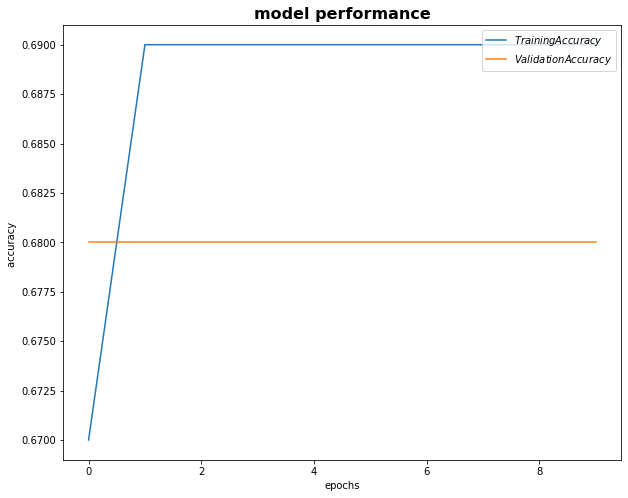

In [27]:
xpoints = np.arange(len(trainLossList))
ypoints4 = trainAccyList
ypoints6 = valAccyList

plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(xpoints, ypoints4, label = "$ Training Accuracy $" )
plt.plot(xpoints, ypoints6, label = "$ Validation Accuracy $" )

plt.legend(loc="upper right")

plt.title("model performance", fontsize=16, fontweight='bold')
plt.xlabel("epochs")
plt.ylabel("accuracy ")
plt.show()

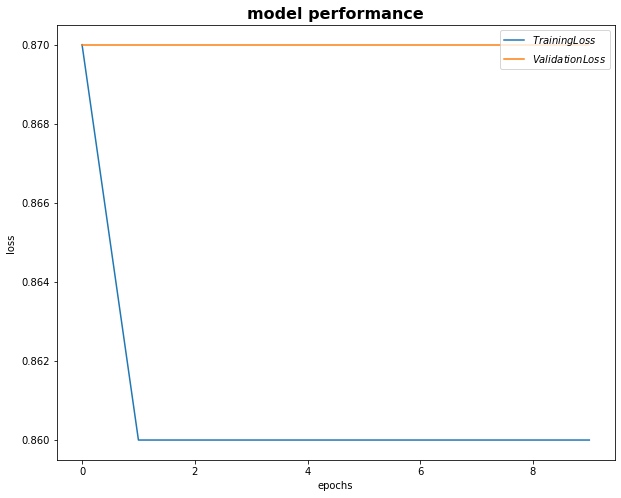

In [28]:
xpoints = np.arange(len(trainLossList))
ypoints0 = trainLossList
ypoints2 = valLossList


plt.rcParams['figure.figsize'] = [10,8]
plt.plot(xpoints, ypoints0 , label = "$ Training Loss $" )
plt.plot(xpoints, ypoints2, label = "$ Validation Loss $" )

plt.legend(loc="upper right")

plt.title("model performance", fontsize=16, fontweight='bold')
plt.xlabel("epochs")
plt.ylabel("loss ")
plt.show()

### A utility function to classify any tweets

1.   saved weights are used to classify any input string to predict a label
2.   a cached tokenizer which was saved earlier is used


In [29]:
#load weights and tokenizer

path='./saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open('./tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 
categories = {0: "Negative", 1:"Positive", 2:"Neutral"}

import spacy
nlp = spacy.load('en')

def classify_tweet(tweet):
    
    
    
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(tweet)] 
    #print(tokenized)
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized] 
    #print(indexed)       
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    #print(tensor)
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    #print(tensor)
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    #print(length_tensor)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor)

    _, pred = torch.max(prediction, 1) 
    #print(pred.size(),pred)
    
    return categories[pred.item()]

### Classify a single sentence and print the hidden state at each step of encoder and decoder

In [30]:
printEncoderDecoderOutput = True
classify_tweet("An invalid explanation for why Nixon will let women on the army.")

encdr word  0 torch.Size([1, 100]) tensor([[-1.8710e-03, -8.0427e-01, -6.1747e-11, -3.7839e-02, -8.4277e-03,
         -1.7091e-02, -2.6354e-05, -2.4499e-04,  7.9232e-01, -6.6541e-03,
          8.2659e-11, -6.4073e-06, -9.3472e-02,  7.1891e-01, -7.6157e-01,
         -7.0244e-01, -2.9770e-07,  7.9476e-01, -8.6679e-01,  8.4065e-07,
          6.9593e-01,  7.6414e-01,  7.6146e-01,  1.5395e-03,  8.8270e-02,
         -6.6078e-07,  7.1764e-02, -7.4168e-01,  6.1294e-01, -6.5134e-01,
         -7.6126e-01,  6.9115e-03, -6.2946e-02,  5.2571e-01, -7.1021e-01,
         -6.6858e-02,  6.7826e-01,  2.6072e-03, -7.2935e-01, -5.3951e-05,
          7.3473e-08,  7.6043e-01, -7.0153e-01,  7.7333e-01, -6.5393e-01,
          8.9022e-04, -5.3442e-07, -6.2792e-02, -1.0654e-10,  7.4090e-01,
         -2.7676e-05,  6.9301e-01, -2.8549e-01, -7.3232e-01,  1.3171e-07,
         -6.9449e-01,  7.5401e-01, -3.7342e-11, -7.3943e-01, -1.9820e-02,
          1.0424e-03,  1.1207e-04, -4.6235e-22, -1.0200e-08,  7.9701e-01,
   

'Negative'

## Testing the model on 10 random review comments from the validation set to predict the label

In [31]:
import random 

from IPython.display import display, Markdown

TESTSAMPLE = 10

validindex = np.arange (len(valid))

printEncoderDecoderOutput = False
randindex = random.choices(validindex , k=10)

sentenceLabelPrediction = []

for i in range(TESTSAMPLE)  :
  slp = {}
  out = vars(valid.examples[randindex[i]])
  
  true_label = categories[out['label']]
  in_tweet = ' '.join(out['tweet'])
  pred_label = classify_tweet(in_tweet)

  strTruelabel = 'True label: ' + str(true_label)
  strPredlabel = 'Predicted label: ' +  str(pred_label)
  strSentence =  'Input Sentence: ' + in_tweet
  slp['Truelabel'] = true_label
  slp['Predictedlabel'] = pred_label
  slp['Input Sentence'] = in_tweet

  sentenceLabelPrediction.append(slp)
  
  lineSeparator = '---------------------------------'
  display(Markdown('<strong>{}</strong><br><br><strong>{}</strong><br><br>{}<br><br><strong>{}</strong><br><br>'.format(strTruelabel , strPredlabel , strSentence , lineSeparator)))






<strong>True label: Negative</strong><br><br><strong>Predicted label: Negative</strong><br><br>Input Sentence: BUM ! Obama " threatens " supreme court justices considering repealing his unconstitutional healthcare law . Nice move bum !<br><br><strong>---------------------------------</strong><br><br>

<strong>True label: Negative</strong><br><br><strong>Predicted label: Negative</strong><br><br>Input Sentence: @ericbolling # Hillary 's gon na challenge # Obama<br><br><strong>---------------------------------</strong><br><br>

<strong>True label: Negative</strong><br><br><strong>Predicted label: Negative</strong><br><br>Input Sentence: RT @ohgirlphrase : American kid " You 're from the UK ? Ohhh cool , So do you have tea with the Queen ? " . British kid : " Do you like , go to Mcdonalds with Obama ?<br><br><strong>---------------------------------</strong><br><br>

<strong>True label: Negative</strong><br><br><strong>Predicted label: Negative</strong><br><br>Input Sentence: @AC360   President Obama is a Constitutional Law scholar - give him credit and the respect that he deserves .   @JaySekulow is annoying .<br><br><strong>---------------------------------</strong><br><br>

<strong>True label: Positive</strong><br><br><strong>Predicted label: Negative</strong><br><br>Input Sentence: Obama signs JOBS Act to boost startup firms - http://t.co/TFuPTCwT<br><br><strong>---------------------------------</strong><br><br>

<strong>True label: Negative</strong><br><br><strong>Predicted label: Negative</strong><br><br>Input Sentence: RT @ohgirlphrase : American kid " You 're from the UK ? Ohhh cool , So do you have tea with the Queen ? " . British kid : " Do you like , go to Mcdonalds with Obama ?<br><br><strong>---------------------------------</strong><br><br>

<strong>True label: Negative</strong><br><br><strong>Predicted label: Negative</strong><br><br>Input Sentence: It 's incredible that something like # WhatsRomneyHiding would be trending . Yet Obama is sneakiest , harmful person and no one says anything .<br><br><strong>---------------------------------</strong><br><br>

<strong>True label: Negative</strong><br><br><strong>Predicted label: Negative</strong><br><br>Input Sentence: A " legislator " who 'd never passed legislation . A " law professor " who 'd never published a law review article ... Is Obama fictional ? # hhrs<br><br><strong>---------------------------------</strong><br><br>

<strong>True label: Negative</strong><br><br><strong>Predicted label: Negative</strong><br><br>Input Sentence: RT @anna12061 : Another Obama Buddy !<br><br><strong>---------------------------------</strong><br><br>

<strong>True label: Negative</strong><br><br><strong>Predicted label: Negative</strong><br><br>Input Sentence: @obama start tweeting dang<br><br><strong>---------------------------------</strong><br><br>

### store the information for further analysis

In [32]:
diagnosticDict = {}

diagnosticDict['num_hidden_nodes'] = num_hidden_nodes
diagnosticDict['epochs'] = N_EPOCHS
diagnosticDict['lr'] = learning_rate
diagnosticDict['batchsize'] = batch_size
diagnosticDict['trainLossList'] = trainLossList
diagnosticDict['valLossList']= valLossList
diagnosticDict['trainAccyList'] = trainAccyList
diagnosticDict['valAccyList'] = valAccyList
diagnosticDict['sentencelabelpredict'] = sentenceLabelPrediction

#diagnosticDict

In [33]:
import json

with open("encdr_dcdr_lstmdiagnostic.json", "a") as out_file:
  json.dump(diagnosticDict, out_file, indent = 6)
